## 1. 读入所有数据

In [1]:
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv('data/train.csv')
members = pd.read_csv('data/members.csv')
songs = pd.read_csv('data/songs.csv')
song_extra_info = pd.read_csv('data/song_extra_info.csv')

In [3]:
data = train.merge(members, left_on='msno', right_on='msno', how='left') \
        .merge(songs, left_on='song_id', right_on='song_id', how='left') \
        .merge(song_extra_info, left_on='song_id', right_on='song_id', how='left')

* 训练数据表：
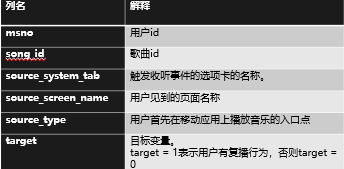

* 用户信息表：

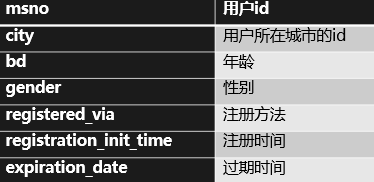

* 歌曲信息表：
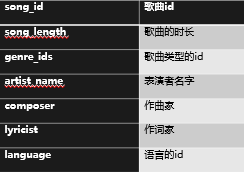

* 歌曲的补充信息表

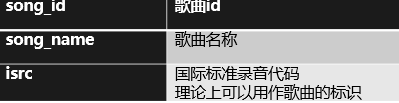

## 2. 处理连续型特征



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002B381F4ECD0>]],
      dtype=object)

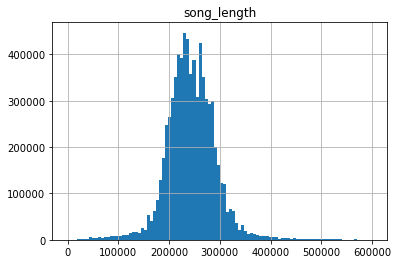

In [6]:
# 数值型特征标准化
# 连续型特征分为多种类别，如歌曲的时长分布呈现类似正态分布，由于其均值和方差都较大，直接输入模型会对模型学习造成很强的数值干扰，一般可以通过特征标准化（z-score标准化）处理
data[['song_length']].hist(range=(0, 600000), bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002B386EBF520>]],
      dtype=object)

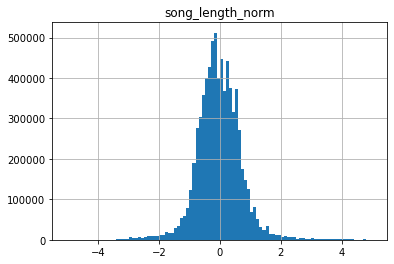

In [7]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
song_length_norm = pd.DataFrame(scalar.fit_transform(data[['song_length']]), columns=['song_length_norm'])
# 进行标准化后，特征的取值范围更合理
song_length_norm.hist(range=[-5, 5], bins=100) 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002B382166BE0>]],
      dtype=object)

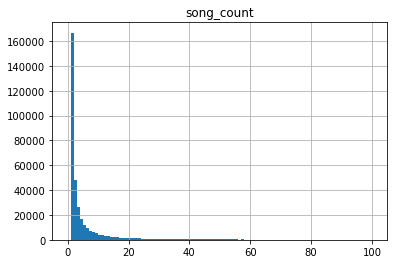

In [8]:
# 长尾分布型数值，如歌曲热度类特征分布及其不均匀，热门歌曲的统计特征会对模型训练造成干扰，一般使用频率分桶方式将其转化为更均匀的分布
song_count = data.groupby('song_id').agg(song_count=('msno', 'count'))
song_count.hist(range=(0, 100), bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002B386FD3E50>]],
      dtype=object)

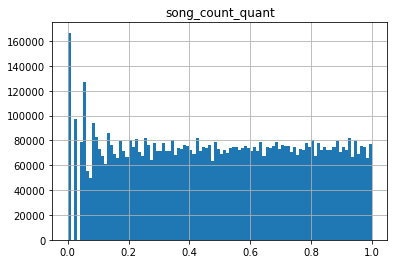

In [9]:
from sklearn.preprocessing import QuantileTransformer
song_count_feature = data[['song_id']].merge(song_count, left_on='song_id', right_on='song_id', how='left')
quant = QuantileTransformer(n_quantiles=10000)
song_count_quant = pd.DataFrame(quant.fit_transform(song_count_feature['song_count'].values.reshape(-1, 1)), columns=['song_count_quant'])
song_count_quant.hist(bins=100)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002B3A7754DC0>],
      dtype=object)

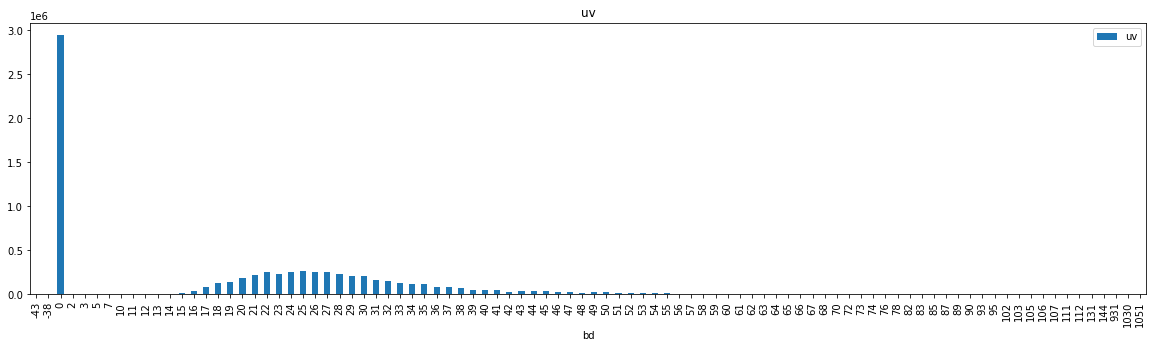

In [10]:
# 数值型特征分桶后one-hot编码
# 还有一类数值型特征可以通过先验知识做预先处理，如用户年龄特别小或特别大的根据经验可以判断极有可能是异常值可以预先筛除，按照年龄分阶段后可以方便模型分别学习不同年龄段的特征情况
data.groupby(['bd'], dropna=False)['msno'].agg(uv='size').sort_values(by='bd', ascending=True).plot.bar(subplots=True, figsize=(20, 5))

In [11]:
data['bd_dist'] = data['bd'].clip(0, 60).replace(0, np.nan).apply(lambda x: x // 5) # 处理异常值后分桶
bd_onehot = pd.get_dummies(data['bd_dist'], columns=['bd_dist'], dummy_na=True, prefix='bd', prefix_sep='_')
bd_onehot

,bd_0.0,bd_1.0,bd_2.0,bd_3.0,bd_4.0,bd_5.0,bd_6.0,bd_7.0,bd_8.0,bd_9.0,bd_10.0,bd_11.0,bd_12.0,bd_nan
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7377413,0,0,0,0,0,1,0,0,0,0,0,0,0,0
7377414,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7377415,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7377416,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## 3. 处理类别型特征

In [12]:
# 类别型转换成one-hot编码表示
onehot_columns = ['source_system_tab', 'source_screen_name', 'source_type', 'language', 'city', 'gender', 'registered_via']
data_onehot = pd.get_dummies(data[onehot_columns], dummy_na=True, columns=onehot_columns)

In [13]:
data_onehot

,source_system_tab_discover,source_system_tab_explore,source_system_tab_listen with,source_system_tab_my library,source_system_tab_notification,source_system_tab_radio,source_system_tab_search,source_system_tab_settings,source_system_tab_nan,source_screen_name_Album more,...,city_nan,gender_female,gender_male,gender_nan,registered_via_3.0,registered_via_4.0,registered_via_7.0,registered_via_9.0,registered_via_13.0,registered_via_nan
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7377413,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
7377414,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
7377415,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
7377416,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [14]:
# 类别型特征转化成向量化表示-hash方法
from sklearn.feature_extraction import FeatureHasher
from collections import Counter
hash_columns = ['genre_ids', 'artist_name', 'composer', 'lyricist']
hash_df_map = {}
feature_size = 16
for column in hash_columns:
    hash = FeatureHasher(n_features=feature_size, input_type='dict')
    data_count = data[column].apply(lambda x: Counter(str(x).split('|'))).values
    hash_arr = hash.fit_transform(data_count).todense()
    hash_df_map[column] = pd.DataFrame(hash_arr, columns=[column + '_' + str(i) for i in range(feature_size)])

In [15]:
hash_df_map['genre_ids']

,genre_ids_0,genre_ids_1,genre_ids_2,genre_ids_3,genre_ids_4,genre_ids_5,genre_ids_6,genre_ids_7,genre_ids_8,genre_ids_9,genre_ids_10,genre_ids_11,genre_ids_12,genre_ids_13,genre_ids_14,genre_ids_15
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7377413,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0
7377414,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7377415,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7377416,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
from sklearn.preprocessing import LabelEncoder
user_le = LabelEncoder()
user_song = pd.DataFrame(user_le.fit_transform(data['msno'].values), columns=['user_idx'])
song_le = LabelEncoder()
user_song['song_idx'] = song_le.fit_transform(data['song_id'].values)   
user_song

,user_idx,song_idx
0,8158,74679
1,17259,223479
2,17259,120758
3,17259,23707
4,8158,33308
...,...,...
7377413,4211,187659
7377414,18266,354712
7377415,18266,51546
7377416,1216,102430


In [17]:
inversed_user_idx = user_le.inverse_transform(np.arange(user_song['user_idx'].unique().shape[0])).reshape(-1, 1)
inversed_song_idx = song_le.inverse_transform(np.arange(user_song['song_idx'].unique().shape[0])).reshape(-1, 1)

In [19]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
label, user_idx, song_idx = data['target'].values, user_song['user_idx'].values, user_song['song_idx'].values
user_song_matrix = csr_matrix((label, (user_idx, song_idx)))

dimension = 32
svd = TruncatedSVD(n_components=dimension)
user_vec = svd.fit_transform(user_song_matrix)
song_vec = svd.components_.T

user_vec_df = pd.DataFrame(np.concatenate([inversed_user_idx, user_vec], axis=1), columns=['msno'] + ['user_vec_' + str(i) for i in range(dimension)]).reset_index()
song_vec_df = pd.DataFrame(np.concatenate([inversed_song_idx, song_vec], axis=1), columns=['song_id'] + ['song_vec_' + str(i) for i in range(dimension)]).reset_index()

In [20]:
user_vec_df

,index,msno,user_vec_0,user_vec_1,user_vec_2,user_vec_3,user_vec_4,user_vec_5,user_vec_6,user_vec_7,...,user_vec_22,user_vec_23,user_vec_24,user_vec_25,user_vec_26,user_vec_27,user_vec_28,user_vec_29,user_vec_30,user_vec_31
0,0,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,3.831761,1.07703,-0.222905,-0.719829,0.059112,-0.277823,-1.772913,-1.83519,...,-0.96932,1.131233,1.101915,-0.100173,1.117023,0.19978,-0.43772,0.373575,-0.071789,0.349678
1,1,++AH7m/EQ4iKe6wSlfO/xXAJx50p+fCeTyF90GoE9Pg=,3.798494,-0.69724,1.497,0.123107,-1.419252,0.508702,0.587856,-0.042394,...,-0.317867,-0.895312,0.240719,0.236666,-0.587335,0.671553,-0.350323,-0.19876,0.09404,-0.350346
2,2,++e+jsxuQ8UEnmW40od9Rq3rW7+wAum4wooXyZTKJpk=,0.975564,0.598702,0.290352,-0.070274,-0.242177,-0.280704,-0.119979,0.073897,...,0.278869,0.140823,-0.002035,-0.420578,-0.096834,-0.111763,0.159649,0.105975,-0.341942,-0.266321
3,3,++xWL5Pbi2CpG4uUugigQahauM0J/sBIRloTNPBybIU=,0.000269,0.000216,0.000589,0.000493,0.000076,0.000084,-0.000181,-0.001186,...,-0.000367,-0.001278,0.000627,0.000515,-0.000017,-0.000602,-0.001928,-0.001433,0.000238,0.001206
4,4,+/SKX44s4ryWQzYzuV7ZKMXqIKQMN1cPz3M8CJ8CFKU=,3.381293,-1.675413,-0.290818,-1.131252,-1.217084,-2.616068,0.862784,-0.058083,...,0.432179,0.125806,-0.498591,0.584816,0.202595,0.347508,0.404462,0.567683,0.547549,-0.307523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30750,30750,zzTnhToV1XfDIsDJ1YaXM3Q05xV54T8Q0zTJkakXsks=,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0
30751,30751,zzZBJUYXrb168A4Ff4sA8L2iOH0x4ciKdD6WkV53XaE=,0.619602,-0.546799,0.153298,0.356985,0.062533,0.077453,0.006142,0.559743,...,0.900379,0.426337,-0.784783,-0.113004,0.277113,0.467251,-0.93027,-1.30261,1.221156,0.838915
30752,30752,zzompfSaMamqvjyCMYvgUBwYrxh8fHE40z3f73CQoak=,1.177918,-1.354396,0.639159,-0.304866,0.042222,-0.396558,-0.064115,-0.301845,...,0.282485,0.387207,0.001587,-0.049829,-0.058289,0.262094,-0.038036,0.078259,-0.232381,0.087693
30753,30753,zzqc2ja7z10FtSpagYVcAZXg/gPRq7wcDZuNFj+zJSU=,1.353348,0.674925,0.72621,0.351222,-0.123305,0.193109,0.123461,0.25493,...,0.477552,0.210053,0.088893,-0.012684,-0.501306,-0.121115,-0.229437,0.192321,-0.313214,-0.434053


In [21]:
song_vec_df

,index,song_id,song_vec_0,song_vec_1,song_vec_2,song_vec_3,song_vec_4,song_vec_5,song_vec_6,song_vec_7,...,song_vec_22,song_vec_23,song_vec_24,song_vec_25,song_vec_26,song_vec_27,song_vec_28,song_vec_29,song_vec_30,song_vec_31
0,0,+++2AEoM0d8iZTdbnAjUm35bnGKGMXdZJSv4rrWK6JQ=,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,...,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0
1,1,++/ACCkEN/+VtgrJxEqeRgRmV4y8pcarDJ9T/yRAi1E=,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,...,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0
2,2,++/lJNswCU+za2pYB0cWIbGL5UzWIKtfweX20+GImZA=,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0
3,3,++4/NK5qpbTZWln/6UmykB8cLfRTCCj8E36IKZVzBjM=,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,...,-0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0
4,4,++4Ihbdp0juQ9ldp9DysOL1WTLHIiawg7cnBTn55I/k=,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,...,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359961,359961,zzvfk6Np17ieMkvG9CQNxdDYQENCVLXuYx5VWrNhCvg=,0.00003,-0.000006,0.000105,-0.000018,0.000001,-0.000049,-0.00001,-0.000187,...,0.000221,0.000336,0.000014,-0.000021,-0.000165,0.00025,-0.000235,0.000219,-0.000096,-0.000304
359962,359962,zzwCHrZc0TezilVRRTbsiWY6ORNpBq1Zv8GGtHT2xlk=,0.000001,-0.000004,0.000001,0.000009,0.000016,-0.0,-0.000025,0.000012,...,0.00013,0.000007,-0.000162,-0.000084,0.000022,0.00014,-0.000296,-0.000328,0.000257,0.000179
359963,359963,zzwePOl2yF8NLVL7ZfTU2CmtlwnjSruAOpcYiod9iHs=,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0
359964,359964,zzxGtSW9L/V3sRNKZbkOgziHtftZ9/oNvETOTY/QHr8=,0.000034,-0.000075,0.000116,-0.000069,-0.00003,-0.000033,-0.000209,0.000048,...,0.000302,0.000304,0.000119,-0.000011,-0.000121,-0.000192,0.000188,0.000331,-0.000052,-0.000393


## 4. 合并特征划分训练集


In [22]:
user_vec_df

,index,msno,user_vec_0,user_vec_1,user_vec_2,user_vec_3,user_vec_4,user_vec_5,user_vec_6,user_vec_7,...,user_vec_22,user_vec_23,user_vec_24,user_vec_25,user_vec_26,user_vec_27,user_vec_28,user_vec_29,user_vec_30,user_vec_31
0,0,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,3.831761,1.07703,-0.222905,-0.719829,0.059112,-0.277823,-1.772913,-1.83519,...,-0.96932,1.131233,1.101915,-0.100173,1.117023,0.19978,-0.43772,0.373575,-0.071789,0.349678
1,1,++AH7m/EQ4iKe6wSlfO/xXAJx50p+fCeTyF90GoE9Pg=,3.798494,-0.69724,1.497,0.123107,-1.419252,0.508702,0.587856,-0.042394,...,-0.317867,-0.895312,0.240719,0.236666,-0.587335,0.671553,-0.350323,-0.19876,0.09404,-0.350346
2,2,++e+jsxuQ8UEnmW40od9Rq3rW7+wAum4wooXyZTKJpk=,0.975564,0.598702,0.290352,-0.070274,-0.242177,-0.280704,-0.119979,0.073897,...,0.278869,0.140823,-0.002035,-0.420578,-0.096834,-0.111763,0.159649,0.105975,-0.341942,-0.266321
3,3,++xWL5Pbi2CpG4uUugigQahauM0J/sBIRloTNPBybIU=,0.000269,0.000216,0.000589,0.000493,0.000076,0.000084,-0.000181,-0.001186,...,-0.000367,-0.001278,0.000627,0.000515,-0.000017,-0.000602,-0.001928,-0.001433,0.000238,0.001206
4,4,+/SKX44s4ryWQzYzuV7ZKMXqIKQMN1cPz3M8CJ8CFKU=,3.381293,-1.675413,-0.290818,-1.131252,-1.217084,-2.616068,0.862784,-0.058083,...,0.432179,0.125806,-0.498591,0.584816,0.202595,0.347508,0.404462,0.567683,0.547549,-0.307523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30750,30750,zzTnhToV1XfDIsDJ1YaXM3Q05xV54T8Q0zTJkakXsks=,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0
30751,30751,zzZBJUYXrb168A4Ff4sA8L2iOH0x4ciKdD6WkV53XaE=,0.619602,-0.546799,0.153298,0.356985,0.062533,0.077453,0.006142,0.559743,...,0.900379,0.426337,-0.784783,-0.113004,0.277113,0.467251,-0.93027,-1.30261,1.221156,0.838915
30752,30752,zzompfSaMamqvjyCMYvgUBwYrxh8fHE40z3f73CQoak=,1.177918,-1.354396,0.639159,-0.304866,0.042222,-0.396558,-0.064115,-0.301845,...,0.282485,0.387207,0.001587,-0.049829,-0.058289,0.262094,-0.038036,0.078259,-0.232381,0.087693
30753,30753,zzqc2ja7z10FtSpagYVcAZXg/gPRq7wcDZuNFj+zJSU=,1.353348,0.674925,0.72621,0.351222,-0.123305,0.193109,0.123461,0.25493,...,0.477552,0.210053,0.088893,-0.012684,-0.501306,-0.121115,-0.229437,0.192321,-0.313214,-0.434053


In [23]:
data_merged = data[['target']].merge(song_length_norm, left_index=True, right_index=True)\
    .merge(bd_onehot, left_index=True, right_index=True) \
    .merge(data_onehot, left_index=True, right_index=True) \
    .merge(hash_df_map['genre_ids'], left_index=True, right_index=True) \
    .merge(hash_df_map['artist_name'], left_index=True, right_index=True) \
    .merge(hash_df_map['composer'], left_index=True, right_index=True) \
    .merge(hash_df_map['lyricist'], left_index=True, right_index=True) \
    .merge(user_vec_df.drop(['id'], axis=1), on='msno', how='left')\
    .merge(song_vec_df.drop(['id'], axis=1), on='song_id', how='left')

KeyError: "['id'] not found in axis"

In [ ]:
data_merged